In [2]:
! pip install --user tensorflow-data-validation

     |████████████████████████████████| 10.4 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 44.8 MB/s eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.8.1-py3-none-any.whl size=121165 sha256=13b3cb2324edf142f7b4f9f2d29f43b07d2bacf1aa5aeb4addd59ea3cff7a2d5
  Stored in directory: /root/.cache/pip/wheels/46/91/e3/0fced4f5fbc0a051a5667096826186c9ff60f2d0e9bf0f1cdc
Successfully built absl-py
ERROR: tfx-bsl 0.21.3 has requirement apache-beam[gcp]<2.18,>=2.17, but you'll have apache-beam 2.19.0 which is incompatible.
ERROR: tfx-bsl 0.21.3 has requirement pyarrow<0.16.0,>=0.15.0, but you'll have pyarrow 0.16.0 which is incompatible.


In [164]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import tensorflow_data_validation as tfdv
import seaborn as sns
import operator
from sklearn.metrics import *
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of student_utils failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/workspace/starter_code/student_utils.py", line 15
    df_new = 

In [4]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [5]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


Testing for lined and encounter level

Line: Total number of rows > Number of Unique Encounters
Encounter level: Total Number of Rows = Number of Unique Encounters

In [7]:
# Line Test
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [8]:
# Encounter Test
try:
    assert len(df) == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


In [9]:
print(df['patient_nbr'].nunique())
print(len(df))
print(df['encounter_id'].nunique())
print(df['primary_diagnosis_code'].nunique())
print(df['number_diagnoses'].nunique())

71518
143424
101766
717
16


Since the data is at line level(number of encounters<total number of rows), we can aggregate on primary_diagnosis_code

Student Response:??

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [10]:
######NOTE: The visualization will only display in Chrome browser. ########
full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
tfdv.visualize_statistics(full_data_stats)

/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/arrow/arrow_util.py:236: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  types.FeaturePath([column_name]), column.data.chunk(0), weights):


AttributeError: module 'tfx_bsl.arrow.array_util' has no attribute 'ListLengthsFromListArray' [while running 'GenerateStatistics/RunStatsGenerators/GenerateSlicedStatisticsImpl/RunCombinerStatsGenerators/WindowIntoDiscarding']

Tried running the tfdv library, failing. Switcchcing over to manual EDA

In [11]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,143424.0,1.674290e+08,1.019046e+08,12522.0,88295964.0,154763706.0,232089688.5,443867222.0
patient_nbr,143424.0,5.493608e+07,3.857840e+07,135.0,23572188.0,46307830.5,88236270.0,189502619.0
admission_type_id,143424.0,2.027694e+00,1.427585e+00,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,143424.0,3.655316e+00,5.219279e+00,1.0,1.0,1.0,3.0,28.0
admission_source_id,143424.0,5.701096e+00,4.064532e+00,1.0,1.0,7.0,7.0,25.0
time_in_hospital,143424.0,4.490190e+00,2.999667e+00,1.0,2.0,4.0,6.0,14.0
number_outpatient,143424.0,3.624289e-01,1.249295e+00,0.0,0.0,0.0,0.0,42.0
number_inpatient,143424.0,6.008548e-01,1.207934e+00,0.0,0.0,0.0,1.0,21.0
number_emergency,143424.0,1.950859e-01,9.204102e-01,0.0,0.0,0.0,0.0,76.0
num_lab_procedures,143424.0,4.325575e+01,1.965732e+01,1.0,32.0,44.0,57.0,132.0


In [13]:
df.count()

encounter_id                143424
patient_nbr                 143424
race                        143424
gender                      143424
age                         143424
weight                      143424
admission_type_id           143424
discharge_disposition_id    143424
admission_source_id         143424
time_in_hospital            143424
payer_code                  143424
medical_specialty           143424
primary_diagnosis_code      143424
other_diagnosis_codes       143424
number_outpatient           143424
number_inpatient            143424
number_emergency            143424
num_lab_procedures          143424
number_diagnoses            143424
num_medications             143424
num_procedures              143424
ndc_code                    119962
max_glu_serum               143424
A1Cresult                   143424
change                      143424
readmitted                  143424
dtype: int64

From the above count analysis we can see that all fields but ndc_code has 123424 values, hence concluded that ndc_code has missing values

In [14]:
# Counting total NaN values in the DataFrame
print(" \nCount total NaN in the DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in the DataFrame : 

 23462


Checking missing values for all columns

In [15]:
columns = df.columns.values.tolist()
for col in columns:
    print(col + " ", df[col].isna().sum())

encounter_id  0
patient_nbr  0
race  0
gender  0
age  0
weight  0
admission_type_id  0
discharge_disposition_id  0
admission_source_id  0
time_in_hospital  0
payer_code  0
medical_specialty  0
primary_diagnosis_code  0
other_diagnosis_codes  0
number_outpatient  0
number_inpatient  0
number_emergency  0
num_lab_procedures  0
number_diagnoses  0
num_medications  0
num_procedures  0
ndc_code  23462
max_glu_serum  0
A1Cresult  0
change  0
readmitted  0


In [16]:
#Checking for distribution in numerical fields 
numerical_fields = [col for col in df.columns if df[col].dtype == "int64"]
numerical_fields

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

In [17]:
df_numerical = df[numerical_fields]

In [18]:
df_numerical.head()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,2278392,8222157,6,25,1,1,0,0,0,41,1,1,0
1,149190,55629189,1,1,7,3,0,0,0,59,9,18,0
2,64410,86047875,1,1,7,2,2,1,0,11,6,13,5
3,500364,82442376,1,1,7,2,0,0,0,44,7,16,1
4,16680,42519267,1,1,7,1,0,0,0,51,5,8,0


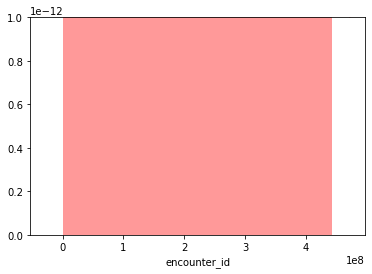

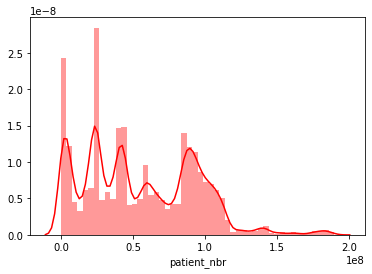

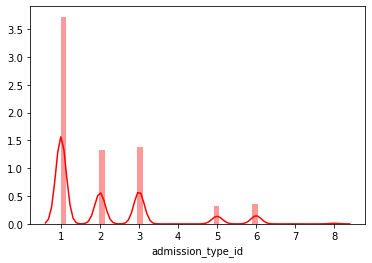

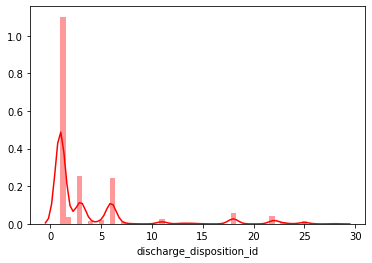

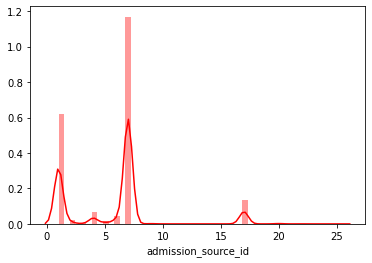

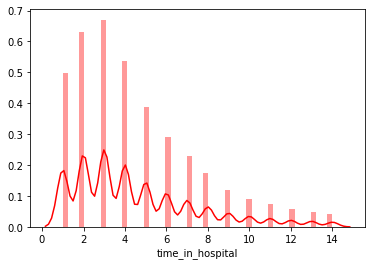

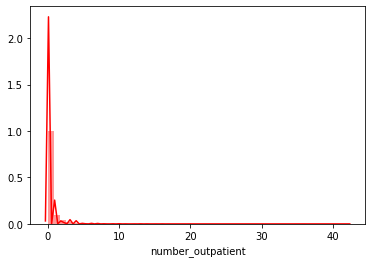

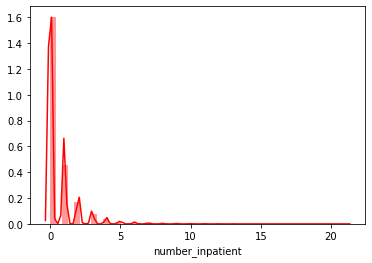

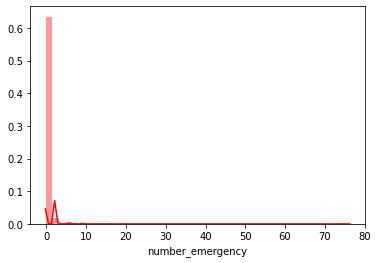

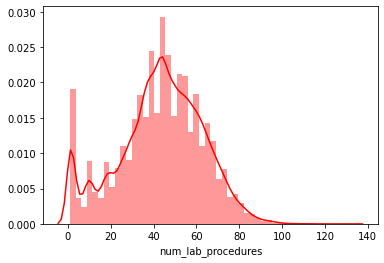

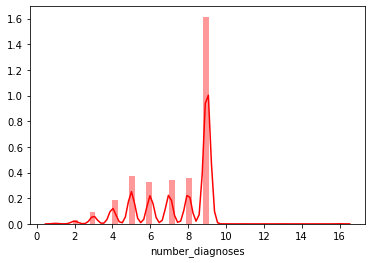

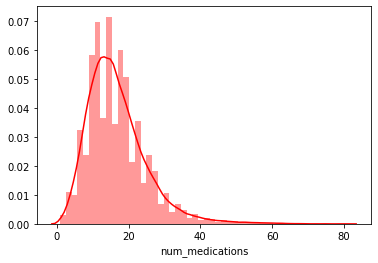

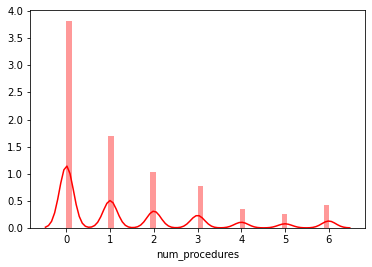

In [19]:
for i in df_numerical.columns:
    sns.distplot(df_numerical[i],color='r',kde=True)
    plt.show()

num_lab_procedures and num_medications have some sort of normal distributions but num_medications is skewed towards the left

In [20]:
dict_cardinality = {}
for i in df.columns:
    dict_cardinality[i] = df[i].nunique()

print(dict_cardinality)

{'encounter_id': 101766, 'patient_nbr': 71518, 'race': 6, 'gender': 3, 'age': 10, 'weight': 10, 'admission_type_id': 8, 'discharge_disposition_id': 26, 'admission_source_id': 17, 'time_in_hospital': 14, 'payer_code': 18, 'medical_specialty': 73, 'primary_diagnosis_code': 717, 'other_diagnosis_codes': 19374, 'number_outpatient': 39, 'number_inpatient': 21, 'number_emergency': 33, 'num_lab_procedures': 118, 'number_diagnoses': 16, 'num_medications': 75, 'num_procedures': 7, 'ndc_code': 251, 'max_glu_serum': 4, 'A1Cresult': 4, 'change': 2, 'readmitted': 3}


Sorting dictionary to find threshold of high cardinality features

In [21]:
{k: v for k, v in sorted(dict_cardinality.items(), key=lambda item: item[1])}

{'change': 2,
 'gender': 3,
 'readmitted': 3,
 'max_glu_serum': 4,
 'A1Cresult': 4,
 'race': 6,
 'num_procedures': 7,
 'admission_type_id': 8,
 'age': 10,
 'weight': 10,
 'time_in_hospital': 14,
 'number_diagnoses': 16,
 'admission_source_id': 17,
 'payer_code': 18,
 'number_inpatient': 21,
 'discharge_disposition_id': 26,
 'number_emergency': 33,
 'number_outpatient': 39,
 'medical_specialty': 73,
 'num_medications': 75,
 'num_lab_procedures': 118,
 'ndc_code': 251,
 'primary_diagnosis_code': 717,
 'other_diagnosis_codes': 19374,
 'patient_nbr': 71518,
 'encounter_id': 101766}

Cardinality refers to the number of unique values contained in a particular column, or field, of a database. In this dataset, encounter_id, patient_nbr, other_diagnosis_code,primary_diagnosis_code,ndc_code, num_lab_procedures have high ccardinality

d. Please describe the demographic distributions in the dataset for the age and gender fields.

Demographic analysis is important to ensure that patient is selected from a broad enough demographic base and the drug is representative of a general population

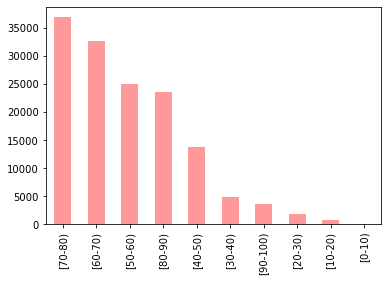

In [22]:
df.age.value_counts().plot(kind='bar',alpha = 0.4,color='r')

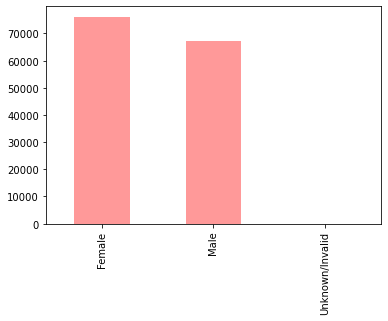

In [23]:
df.gender.value_counts().plot(kind='bar',alpha = 0.4,color='r')

Seeing stacked distribution for comparison

In [24]:
counts = df.groupby(['gender', 'age']).age.count().unstack()
print(counts)

age              [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  \
gender                                                                          
Female             83.0    424.0   1271.0   2708.0   6771.0  12399.0  16011.0   
Male               78.0    309.0    656.0   2256.0   6958.0  12696.0  16729.0   
Unknown/Invalid     NaN      NaN      NaN      NaN      NaN      NaN      1.0   

age              [70-80)  [80-90)  [90-100)  
gender                                       
Female           19666.0  14268.0    2584.0  
Male             17258.0   9259.0    1035.0  
Unknown/Invalid      4.0      NaN       NaN  


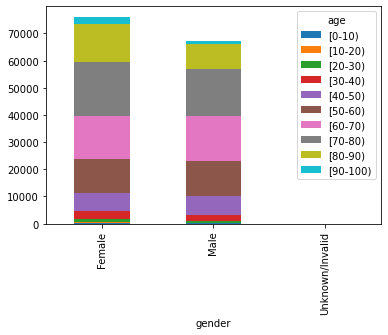

In [25]:
counts.plot(kind='bar', stacked=True)


Demographic Analysis:
    1. More females than makes
    2. More number of old people(>40) than young (<40)
    3. Representation of Ages 0-40 is low
    4. Maximum presence of 70-80
    

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [26]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [37]:
def reduce_dimension_ndc(df, ndc_df):
    '''
    df: pandas dataframe, input dataset
    ndc_df: pandas dataframe, drug code dataset used for mapping in generic names
    return:
        df: pandas dataframe, output dataframe with joined generic drug name
    '''
    df_new = pd.merge(df, ndc_df[['NDC_Code', 'Non-proprietary Name']],
                      how="left",
                      left_on='ndc_code',
                      right_on='NDC_Code')
    return df_new.rename(columns={"Non-proprietary Name": "generic_drug_name"})


In [38]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [39]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [40]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,68071-1701,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,0378-1110,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,Glipizide


In [41]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [63]:
def select_first_encounter(df):
    '''
    df: pandas dataframe, dataframe with all encounters
    return:
        - first_encounter_df: pandas dataframe, dataframe with only the first encounter for a given patient
    '''
    # sort by encounter_id, then group by patient and select first within each group
    return df.sort_values(['encounter_id'], ascending=True).groupby('patient_nbr').head(1)



In [64]:
first_encounter_df = select_first_encounter(reduce_dim_df)

In [66]:
len(first_encounter_df)

71518

In [67]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [68]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [69]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [70]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [71]:
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted',
 'NDC_Code']

In [73]:
agg_drug_df['patient_nbr'].nunique()

54271

In [74]:
agg_drug_df['encounter_id'].nunique()

54271

In [75]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [76]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54266,443841992,184875899,Other,Male,[40-50),?,1,1,7,13,?,?,250.8,730|731,0,0,0,51,9,13,2,0904-6328,None,None,Ch,NO,0904-6328,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
54267,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,0009-3449,None,>7,Ch,>30,0009-3449,[Glyburide],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54268,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,0049-0178,None,>8,Ch,>30,0049-0178,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54269,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,47918-902,None,None,No,>30,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [80]:
df.medical_specialty.value_counts()

?                                   69463
InternalMedicine                    20403
Emergency/Trauma                    11595
Family/GeneralPractice              10508
Cardiology                           7473
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
SportsMedicine                          1
Speech                                  1
Proctology                              1
Pediatrics-InfectiousDiseases           1
Name: medical_specialty, Length: 73, dtype: int64

In [77]:
df.weight.value_counts()

?            139122
[75-100)       1817
[50-75)        1133
[100-125)       890
[125-150)       200
[25-50)         118
[0-25)           67
[150-175)        55
[175-200)        18
>200              4
Name: weight, dtype: int64

In [78]:
df.payer_code.value_counts()

?     54190
MC    46532
HM     8784
SP     7613
BC     6991
MD     4983
CP     3687
UN     3665
CM     2971
OG     1532
PO      919
DM      757
WC      230
CH      208
OT      160
MP      122
SI       79
FR        1
Name: payer_code, dtype: int64

In [81]:
numerical_fields

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

In [85]:
for i in numerical_fields:
    print(df[i].value_counts())

63415968     6
63184686     6
58316058     6
60016020     6
110310714    6
            ..
59620986     1
11112060     1
94477950     1
103436358    1
396736952    1
Name: encounter_id, Length: 101766, dtype: int64
90609804     52
89472402     50
91751121     50
62352252     46
84397842     41
             ..
152901392     1
23189256      1
9537282       1
31037184      1
2873403       1
Name: patient_nbr, Length: 71518, dtype: int64
1    74713
3    27756
2    26823
6     7015
5     6584
8      488
7       33
4       12
Name: admission_type_id, dtype: int64
1     85308
3     19677
6     18945
18     4658
22     3077
2      2906
11     1911
5      1631
25     1285
4      1090
7       782
23      602
13      521
14      432
28      200
8       147
15       93
24       65
9        29
17       20
16       19
19        8
10        6
27        5
20        4
12        3
Name: discharge_disposition_id, dtype: int64
7     80443
1     42773
17     9338
4      4467
6      3108
2      1500
5      1

In [82]:
categorical_fields = df.columns.drop(numerical_fields)
categorical_fields

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [86]:
for i in categorical_fields:
    print(df[i].value_counts())

Caucasian          107688
AfricanAmerican     26427
?                    3309
Hispanic             2938
Other                2174
Asian                 888
Name: race, dtype: int64
Female             76185
Male               67234
Unknown/Invalid        5
Name: gender, dtype: int64
[70-80)     36928
[60-70)     32741
[50-60)     25095
[80-90)     23527
[40-50)     13729
[30-40)      4964
[90-100)     3619
[20-30)      1927
[10-20)       733
[0-10)        161
Name: age, dtype: int64
?            139122
[75-100)       1817
[50-75)        1133
[100-125)       890
[125-150)       200
[25-50)         118
[0-25)           67
[150-175)        55
[175-200)        18
>200              4
Name: weight, dtype: int64
?     54190
MC    46532
HM     8784
SP     7613
BC     6991
MD     4983
CP     3687
UN     3665
CM     2971
OG     1532
PO      919
DM      757
WC      230
CH      208
OT      160
MP      122
SI       79
FR        1
Name: payer_code, dtype: int64
?                                   694

Student response: ??

In [89]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ['admission_type_id',
 'discharge_disposition_id',
 'admission_source_id','weight', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['num_lab_procedures','number_diagnoses','num_medications','num_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [90]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [91]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

By replacing numerical missing values by 0 we are using Arbitrary value imputation. 

Advantages: Arbitrary value imputation is simple to implement and can help your models to capture the importance of missing values, if it exists.
Disadvantages: It can do horrible things to the variable distribution, as it changes the mean, variance, and covariance.

For better results after imputation we could use mean/median/mode imputation techniques or the multivariate imputation techniques (KNN and MissForest)

In [99]:
def cast_df(df, col, d_type=str):
    return df[col].astype(d_type)

def impute_df(df, col, impute_value=0):
    return df[col].fillna(impute_value)
    
def preprocess_df(df, categorical_col_list, numerical_col_list, predictor, categorical_impute_value='nan',             numerical_impute_value=0):
    df[predictor] = df[predictor].astype(float)
    for c in categorical_col_list:
        df[c] = cast_df(df, c, d_type=str)
    for numerical_column in numerical_col_list:
        df[numerical_column] = impute_df(df, numerical_column, numerical_impute_value)
    return df

In [100]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [109]:
def patient_dataset_splitter(df, patient_key='patient_nbr'):
    train_perc, val_perc, test_perc = 0.6, 0.2, 0.2
    df = df.iloc[np.random.permutation(len(df))]
    unique_values = df[patient_key].unique()
    total_values = len(unique_values)
    train_size = int(train_perc * total_values)
    val_size = int(val_perc * total_values)
    test_size = int(test_perc * total_values)
    train = df[df[patient_key].isin(unique_values[:train_size])]
    validation = df[df[patient_key].isin(unique_values[train_size: train_size+val_size])]
    test = df[df[patient_key].isin(unique_values[train_size+val_size:])]

    return train, validation, test

In [110]:
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [111]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [112]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     7318
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2311
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


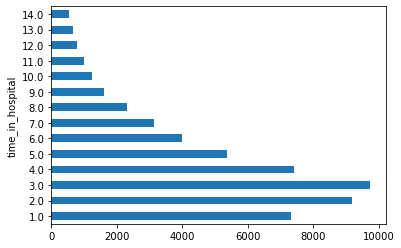

In [113]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4429
2.0     5501
3.0     5832
4.0     4425
5.0     3244
6.0     2354
7.0     1875
8.0     1369
9.0      977
10.0     753
11.0     602
12.0     486
13.0     399
14.0     316
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


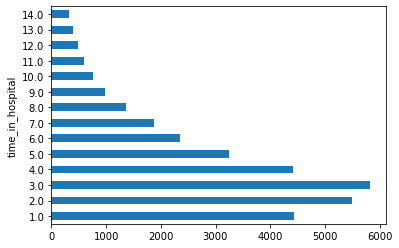

In [114]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1430
2.0     1836
3.0     1937
4.0     1480
5.0     1073
6.0      825
7.0      621
8.0      447
9.0      348
10.0     264
11.0     202
12.0     139
13.0     139
14.0     114
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


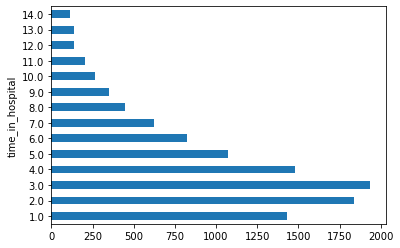

In [115]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

Yes, the split looks similar across all the partitions 

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28572
Male               25697
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


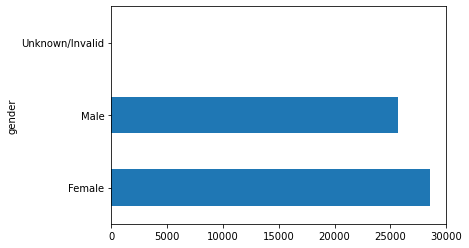

In [116]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17209
Male      15353
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


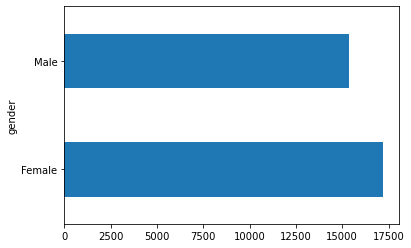

In [117]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5649
Male               5205
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


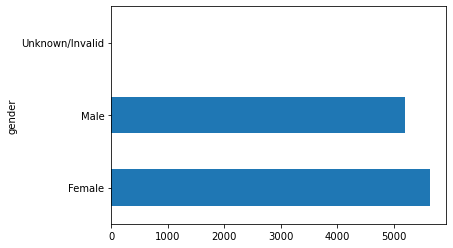

In [118]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [119]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [120]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [121]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [128]:
def create_tf_categorical_feature_cols(categorical_col_list, vocab_dir='./diabetes_vocab/'):

    output_tf_list = []
    for c in categorical_col_list:
        vocab_file_path = os.path.join(vocab_dir,  c + "_vocab.txt")
        num_lines = sum(1 for _ in open(vocab_file_path))
        cat_column = tf.feature_column.categorical_column_with_vocabulary_file(c, vocab_file_path)

        if num_lines > 10:
            print(f'### {c}: #lines: {num_lines}, embedding (categorical)')
            tf_categorical_feature_column = tf.feature_column.embedding_column(cat_column, dimension=10)
        else:
            print(f'### {c}: #lines: {num_lines}, indicator (categorical)')
            tf_categorical_feature_column = tf.feature_column.indicator_column(cat_column)

        output_tf_list.append(tf_categorical_feature_column)

    return output_tf_list

In [129]:
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


### admission_type_id: #lines: 9, indicator (categorical)
INFO:tensorflow:vocabulary_size = 25 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 25 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


### discharge_disposition_id: #lines: 25, embedding (categorical)
INFO:tensorflow:vocabulary_size = 16 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 16 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


### admission_source_id: #lines: 16, embedding (categorical)
INFO:tensorflow:vocabulary_size = 10 in weight is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/weight_vocab.txt.


INFO:tensorflow:vocabulary_size = 10 in weight is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/weight_vocab.txt.


### weight: #lines: 10, indicator (categorical)
INFO:tensorflow:vocabulary_size = 18 in payer_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/payer_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 18 in payer_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/payer_code_vocab.txt.


### payer_code: #lines: 18, embedding (categorical)
INFO:tensorflow:vocabulary_size = 67 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.


INFO:tensorflow:vocabulary_size = 67 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.


### medical_specialty: #lines: 67, embedding (categorical)
INFO:tensorflow:vocabulary_size = 606 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 606 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


### primary_diagnosis_code: #lines: 606, embedding (categorical)
INFO:tensorflow:vocabulary_size = 9418 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.


INFO:tensorflow:vocabulary_size = 9418 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.


### other_diagnosis_codes: #lines: 9418, embedding (categorical)
INFO:tensorflow:vocabulary_size = 233 in ndc_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/ndc_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 233 in ndc_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/ndc_code_vocab.txt.


### ndc_code: #lines: 233, embedding (categorical)
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.


INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.


### max_glu_serum: #lines: 5, indicator (categorical)
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.


INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.


### A1Cresult: #lines: 5, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.


### change: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


### readmitted: #lines: 4, indicator (categorical)
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


### race: #lines: 7, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


### gender: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


### age: #lines: 11, embedding (categorical)
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


### Acarbose: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


### Glimepiride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


### Glipizide: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 2 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 2 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


### Glipizide_And_Metformin_Hcl: #lines: 2, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


### Glipizide_And_Metformin_Hydrochloride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


### Glyburide: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


### Glyburide_And_Metformin_Hydrochloride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


### Glyburide-metformin_Hydrochloride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


### Human_Insulin: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


### Insulin_Human: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


### Metformin_Hcl: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


### Metformin_Hydrochloride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


### Miglitol: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


### Nateglinide: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


### Pioglitazone: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


### Pioglitazone_Hydrochloride_And_Glimepiride: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


### Repaglinide: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


### Rosiglitazone_Maleate: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


### Tolazamide: #lines: 3, indicator (categorical)
INFO:tensorflow:vocabulary_size = 3 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


### Tolbutamide: #lines: 3, indicator (categorical)


In [130]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=0, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(128, 9), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [144]:
import functools
def create_tf_numeric_feature(col, MEAN, STD, default_value=0):

    print(f'### {col}: #mean/std: {MEAN}/{STD}, numeric (normalized)')
    normalizer = functools.partial(normalize_numeric_with_zscore, mean=MEAN, std=STD)
    tf_numeric_feature = tf.feature_column.numeric_column(
        key=col, default_value=default_value, normalizer_fn=normalizer, dtype=tf.float64)

    return tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [145]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [146]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

### num_lab_procedures: #mean/std: 43.65367606412383/20.11274042682631, numeric (normalized)
### number_diagnoses: #mean/std: 7.283919906639642/1.9885591540305891, numeric (normalized)
### num_medications: #mean/std: 16.574504023094406/8.425589828863668, numeric (normalized)
### num_procedures: #mean/std: 1.4267244026779682/1.771780268545815, numeric (normalized)


In [147]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f75b3807b00>, mean=43.65367606412383, std=20.11274042682631))

tf.Tensor(
[[ 0.75]
 [ 1.55]
 [ 1.  ]
 [ 0.15]
 [-0.3 ]
 [ 0.05]
 [-2.05]
 [-0.05]
 [-1.7 ]
 [ 1.05]
 [ 1.45]
 [ 2.3 ]
 [ 0.2 ]
 [ 1.4 ]
 [ 0.2 ]
 [ 0.05]
 [-1.5 ]
 [ 0.95]
 [ 1.4 ]
 [ 0.7 ]
 [ 0.65]
 [ 1.4 ]
 [ 1.05]
 [ 0.45]
 [ 0.3 ]
 [ 0.15]
 [ 0.1 ]
 [ 0.05]
 [ 0.3 ]
 [ 0.85]
 [-0.95]
 [-1.35]
 [-1.95]
 [ 0.55]
 [ 0.  ]
 [ 1.2 ]
 [-0.4 ]
 [ 1.8 ]
 [-0.25]
 [ 0.3 ]
 [-1.4 ]
 [ 1.25]
 [-0.35]
 [-0.45]
 [-0.1 ]
 [-0.85]
 [ 0.3 ]
 [ 0.05]
 [ 1.15]
 [-1.  ]
 [ 0.05]
 [-0.25]
 [ 1.5 ]
 [-1.85]
 [ 0.8 ]
 [-0.65]
 [-0.45]
 [-1.8 ]
 [ 0.  ]
 [ 0.1 ]
 [-0.55]
 [ 0.35]
 [ 0.6 ]
 [-0.65]
 [ 1.  ]
 [ 0.75]
 [ 0.15]
 [-1.7 ]
 [-0.85]
 [ 1.45]
 [ 1.5 ]
 [ 0.5 ]
 [-0.1 ]
 [ 0.25]
 [ 0.05]
 [ 1.15]
 [-0.6 ]
 [-0.65]
 [-1.6 ]
 [ 0.1 ]
 [-0.5 ]
 [ 

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [148]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [149]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [150]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 255 steps, validate for 85 steps
Epoch 1/10
255/255 [==============================] - 15s 58ms/step - loss: 28.8160 - mse: 28.6906 - val_loss: 24.1044 - val_mse: 23.8671
Epoch 2/10
255/255 [==============================] - 9s 36ms/step - loss: 20.5616 - mse: 20.0908 - val_loss: 16.0510 - val_mse: 15.4280
Epoch 3/10
255/255 [==============================] - 9s 36ms/step - loss: 16.0613 - mse: 15.3354 - val_loss: 14.0161 - val_mse: 13.3142
Epoch 4/10
255/255 [==============================] - 9s 36ms/step - loss: 13.3430 - mse: 12.5198 - val_loss: 12.1916 - val_mse: 11.3498
Epoch 5/10
255/255 [==============================] - 9s 35ms/step - loss: 11.8083 - mse: 10.8158 - val_loss: 10.3633 - val_mse: 9.6328
Epoch 6/10
255/255 [==============================] - 9s 35ms/step - loss: 10.6872 - mse: 9.6361 - val_loss: 11.9602 - val_mse: 10.8719
Epoch 7/10
255/255 [==============================] - 9s 35ms/step - loss: 10.4750 - mse: 9.6697 - val_loss: 9.9284 - val_mse: 9.0574
Ep

OPTIONAL: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

Other neural networks like LSTMs,RNNs or NNs with more layers can be used for better performance, later hyper parameter optimisation can be performed using grid or random search

Sample code for RNNS
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [151]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [155]:
def get_mean_std_from_preds(diabetes_yhat):
    '''
    diabetes_yhat: TF Probability prediction object
    '''
    m = diabetes_yhat.mean()
    s = diabetes_yhat.stddev()
    return m, s
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [156]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [157]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,0.203468,10.0,8.608253,0.691003
1,3.333833,6.0,5.604841,0.691937
2,2.714256,1.0,2.226276,0.689078
3,0.352554,2.0,2.193547,0.688526
4,2.753978,1.0,1.540530,0.688552


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [160]:
def get_student_binary_prediction(df, col):
    student_binary_prediction = df[col].apply(lambda x: 1 if x >= 5 else 0).values
    print(f'### Transformed to numpy: {type(student_binary_prediction)}, shape: {student_binary_prediction.shape}')
    return student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Transformed to numpy: <class 'numpy.ndarray'>, shape: (10855,)


In [161]:
student_binary_prediction

array([1, 1, 0, ..., 1, 1, 0])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [162]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [163]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
42924,110888613,Female,Caucasian,10.0,1,1
28746,79474824,Female,Caucasian,6.0,1,1
4922,25934787,Female,Caucasian,1.0,0,0
22312,67291776,Female,Caucasian,2.0,0,0
15476,23425416,Male,Caucasian,1.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [167]:
# AUC, F1, precision and recall
# Summary
print("Confusion matrix", confusion_matrix(pred_test_df['label_value'], pred_test_df['score']))
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))
print("AUC score : ",roc_auc_score(pred_test_df['label_value'], pred_test_df['score']))
print("F1 score : ", f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted'))
print("Precision score: ", precision_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))
print("Recall score : ", recall_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))

Confusion matrix [[5500 1183]
 [1303 2869]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      6683
           1       0.71      0.69      0.70      4172

    accuracy                           0.77     10855
   macro avg       0.76      0.76      0.76     10855
weighted avg       0.77      0.77      0.77     10855

AUC score :  0.755331729927067
F1 score :  0.770329175435986
Precision score:  0.7709811146936896
Recall score :  0.7709811146936896


In [196]:

y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

# functions to plot AUC 
def plot_auc(t_y, p_y):
   
    print("ROC AUC Score: {}".format(roc_auc_score(t_y, p_y)))
    
    # plot roc curve
    fpr, tpr, _ = roc_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (5, 5))
    ax.plot(fpr, tpr, 'b.-', label = 'VGG-Model')
    ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    #ax.legend(loc = 4)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate');
    
    return

# functions to plot confusion matrix
def plot_confusion_mat(t_y, p_y):

    # confusion matrix
    conf_mat = confusion_matrix(y_true=t_y, y_pred=p_y)
    print('Confusion matrix:\n', conf_mat)
    
    # plot matrix
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()



ROC AUC Score: 0.755331729927067


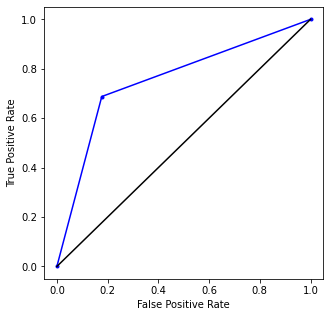

In [197]:
plot_auc(y_true, y_pred)

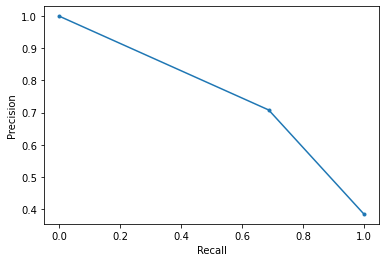

In [198]:

# plot Precision Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision');

Confusion matrix:
 [[5500 1183]
 [1303 2869]]


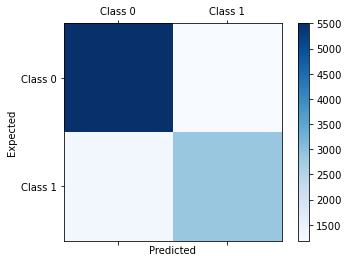

In [199]:
plot_confusion_mat(y_true, y_pred)

In [200]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      6683
           1       0.71      0.69      0.70      4172

    accuracy                           0.77     10855
   macro avg       0.76      0.76      0.76     10855
weighted avg       0.77      0.77      0.77     10855



For the report please be sure to include the following three parts:

With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- Precision is the proportion of positive identifications that are actually correct. Precision provides more confidence in a positive result. Hence, a higher precision will indicate that the patients selected by the model have been correctly identified.
- Precision ignores False Negatives. Hence, a higher precision doesn gaurantee that the patients that were not selected for diabetes testing were actually True Negatives.
- If our main focus is to select a person for diabetes drug testing, our model should have high precision, which means we have to lower the False Positive.
- Recall is proportion of actual positives that were identified correctly. A higher Recall provides more confidence that the test is negative. It however, ignores False Positives.
- In our example, if the aim of the model is to have high recall it means it should have a lower number of false negatives. So if we say the model predicted that a person is not being selected for drug testing, then he should not be actually selected.
- Unfortunately, we can’t have both precision and recall high. If we increase precision, it will reduce recall and vice versa. This is called the precision/recall tradeoff.   


What are some areas of improvement for future iterations?
- We could use a deeper model with more layers like LSTM or RNN for prediction
- We could impute missing values in the data by mean/KNN instead of 0
- We could perform better data preprocessing and feature selection, taking bias and skewness into consideration 
- we ccould perform hyperparameter optimisation for seleccting better hyperparameters

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [202]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [4052]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [185]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,4052,race,?,124,205,36,36,169,88,124,205,329,10855
1,1,binary 0/1,4052,race,AfricanAmerican,730,1212,229,220,992,501,721,1221,1942,10855
2,1,binary 0/1,4052,race,Asian,15,53,4,14,39,11,25,43,68,10855
3,1,binary 0/1,4052,race,Caucasian,3074,5052,877,966,4086,2197,3163,4963,8126,10855
4,1,binary 0/1,4052,race,Hispanic,53,172,17,43,129,36,79,146,225,10855
5,1,binary 0/1,4052,race,Other,56,109,20,24,85,36,60,105,165,10855
6,1,binary 0/1,4052,gender,Female,2078,3571,607,733,2838,1471,2204,3445,5649,10855
7,1,binary 0/1,4052,gender,Male,1973,3232,576,570,2662,1397,1967,3238,5205,10855
8,1,binary 0/1,4052,gender,Unknown/Invalid,1,0,0,0,0,1,1,0,1,10855


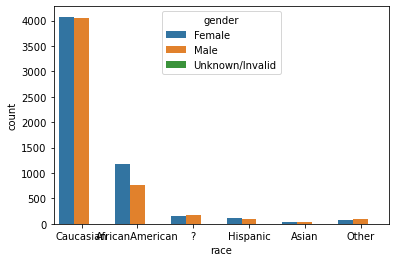

In [186]:
# Plot two metrics
ax_pred_r = sns.countplot(x="race", hue="gender", data=ae_subset_df)
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]
# Is there significant bias in your model for either race or gender?

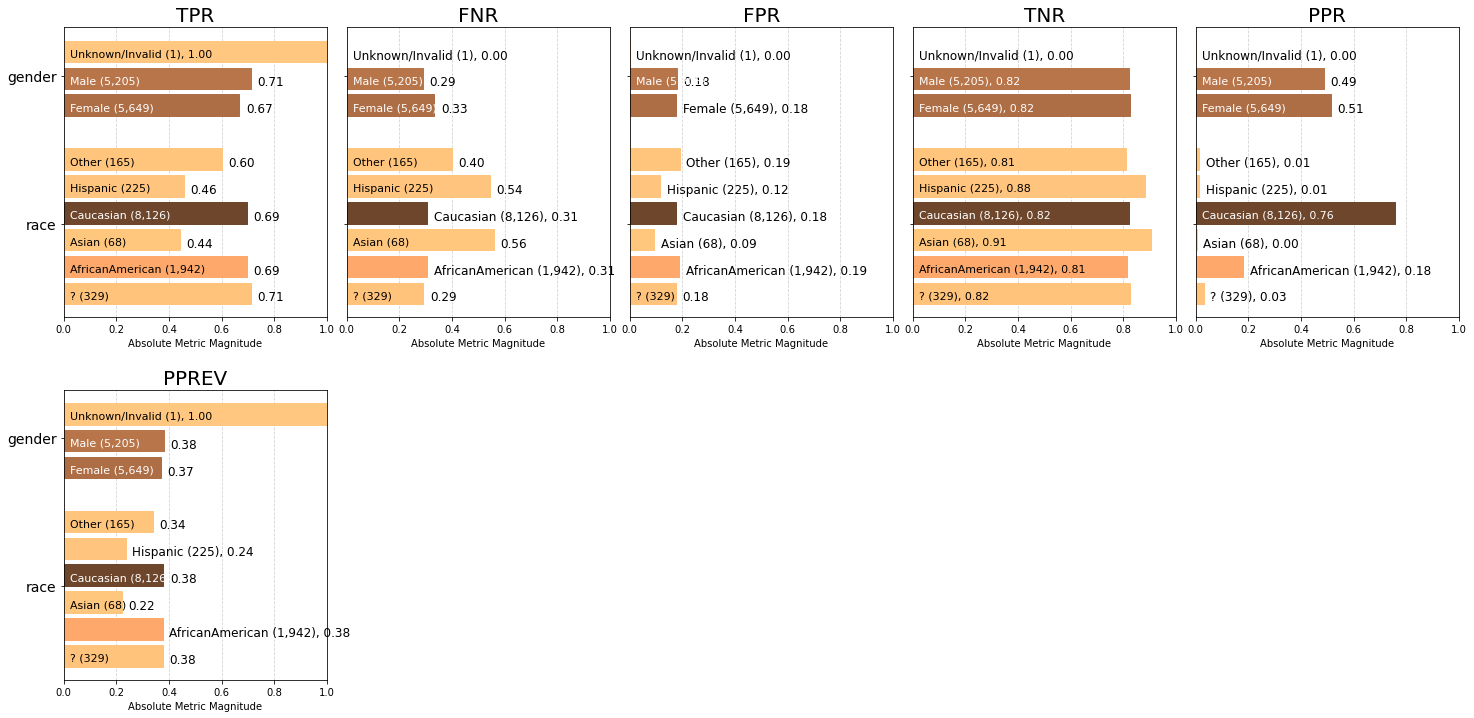

In [187]:

p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fnr', 'fpr', 'tnr', 'ppr', 'pprev'], ncols=5)

Considering PPR and TPR metrics, bias can be observed in both race and gender:

PPR: Predicted Positive Rate (Fraction of all positive predictions across groups that come from specific groups.) If we consider race, can clearly see a bias here since 'Caucasian' has the highest PPR compared to other races by quite a margin.

TPR: True Positive Rate If we consider gender, the 'Male' is likely to have higher selection relative to 'Female' since TPR is higher for Males. This implies that the model is likely to predict more Male patients for testing than females.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

Reference group 'race':'Caucasian', 'gender':'Male' are used in fairness plot



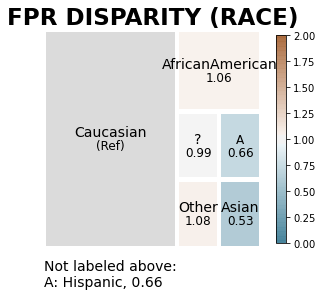

In [188]:
# Reference group fairness plot
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

The above analysis is suggesting that 'African American' is 1.06 times and 'Others' are 1.08 times likely to be falsely identified as a patient for drug testing versus the reference group (Male, Causasian).

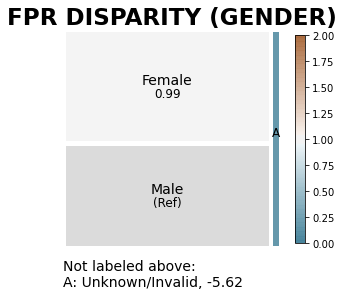

In [189]:

fpr_disparity_g = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

The above analysis is suggesting that 'Female' is .99 times likely to be falsely identified as a patient for drug testing versus the reference group (Male). 

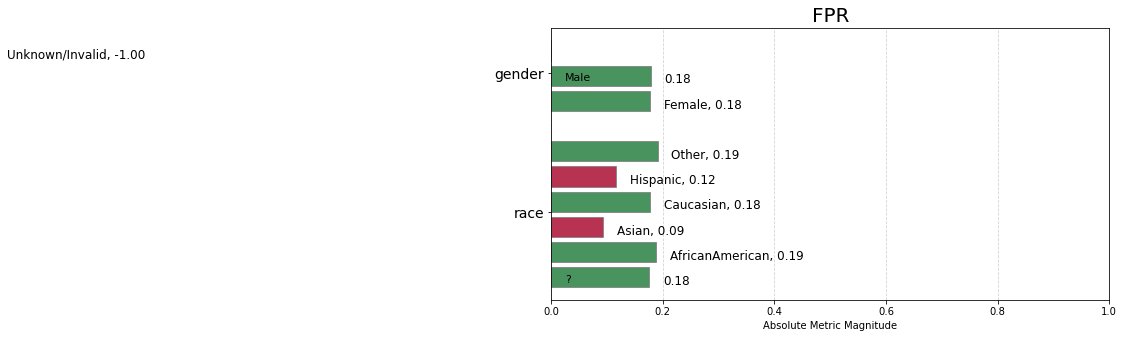

In [190]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)


Absolute Value Fairness Determination

Red = False/Not Fair
Green = True/Fair
The above plot identifies the bias in race where 'Hispanic' and 'Asian' will be falsely identified by the model.

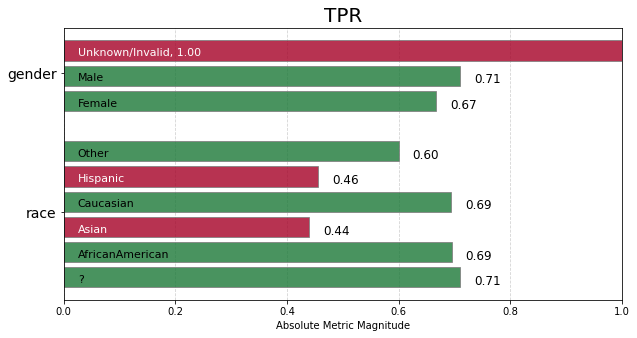

In [194]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)


Bias towards other races as compared to Hispanic and Asian in drug testing selection

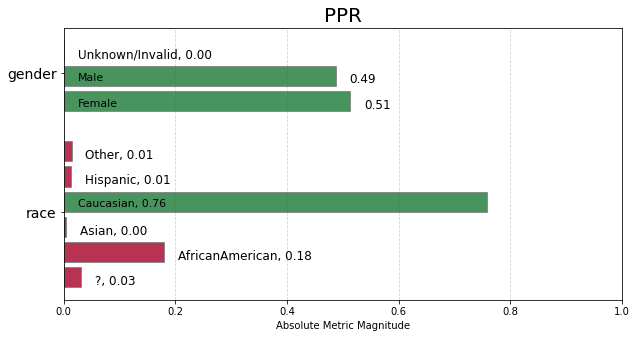

In [195]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)


References- 
I have used stack overflow, tensorflow.org, and open source deep learning repositories for references in the above code